# In this notebook I implement a GP classification experiment


In [1]:
#%% imports 
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from sklearn import datasets
import numpy as np
import scipy.io as scio
import numpy.random as rng
from theano import tensor as tn
from theano import function
from theano import shared
from theano import scan
from theano.tensor.shared_randomstreams import RandomStreams
import lasagne
from lasagne.updates import adagrad, adam
import matplotlib.pyplot as plt
rng.seed(1)
srng = RandomStreams(seed = 1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Develop the model class

In [2]:
#%% GP model
class GP_classification:
    def __init__(self, hyp, X_train, y_train, X_test, y_test):
        self.X = shared(X_train.astype('float64'), 'X');
        self.y = shared(np.squeeze(y_train).astype('float64'), 'y');
        self.Xnew = shared(X_test.astype('float64'), 'Xnew'); # new data to be predicted X
        self.ynew = shared(np.squeeze(y_test).astype('float64'), 'ynew'); # new data to be predicted y
        self.len = tn.shape(self.X)[0];
        # kernel with vectors xi and many vectors xjs
        self.kernel = lambda xi, xjs: hyp[0]**2 * tn.exp(-0.5 * tn.sum((((xi - xjs)/ hyp[1])**2).T, axis = 0))# + hyp[2] * tn.allclose(xi,xjs);
        self.Kmtx, _ = scan(self.kernel , sequences = [self.X], non_sequences = [self.X])
        self.invKmtx = tn.nlinalg.matrix_inverse(self.Kmtx);
        self.linkfn = lambda x: 0.5 * (1.0 + tn.erf(x / np.sqrt(2.0))) * (1 - 2e-50) + 1e-50; # probit link function


        # proposal distribution of z = f(X), z_i~q_i = N(m_i, exp(tau_i)), i \in {1, .... , m}
        self.mu_z = shared(np.zeros(self.len.eval()), 'mu_z');
        self.tau_z = shared(np.zeros(self.len.eval()), 'tau_z');
        self.sigma_z = lasagne.nonlinearities.softplus(self.tau_z);
        self.z = self.mu_z + srng.normal(tn.shape(self.sigma_z)) * self.sigma_z; # scale-location transformation
    
    ##### pred_dist: returns the mean and variance of the predictive distribution #####
    def pred_dist(self):
        Xnew = self.Xnew;
        Kmtx_new, _ = scan(self.kernel , sequences = [Xnew], non_sequences = [self.X])
        mu_znew = tn.dot(tn.dot(Kmtx_new, self.invKmtx), self.mu_z);

        Kmtx_newii = tn.diag(scan(self.kernel , sequences = [Xnew], non_sequences = [Xnew])[0])
        A = tn.diag(self.sigma_z**2);
        sigma_znew = tn.sqrt(Kmtx_newii + tn.diag(tn.dot(tn.dot(
                            Kmtx_new,  
                            (self.invKmtx - tn.dot(tn.dot(self.invKmtx, A), self.invKmtx))), 
                            Kmtx_new.T)));
        return mu_znew, sigma_znew
        
    ##### pred_error: returns the prediction error on test data #####
    def pred_error(self):
        mu = self.pred_dist()[0];
        sigma = self.pred_dist()[1];
        pclass1 = self.linkfn(mu / tn.sqrt(1. + sigma**2));
        est_y = pclass1>0.5;
        correct = tn.eq(est_y, self.ynew);
        per_error = (1. - tn.sum(correct)/(self.ynew.shape[0]+0.))*100.;
        return per_error
        
    ##### logprior_prob: returns the log prior probability of the latent z #####
    def logprior_prob(self, z):
        """the prior = p(z) = N(0, K)"""
        logprior = -0.5 * tn.dot(tn.dot(z.T, self.invKmtx), z.T) - 0.5 * tn.log(tn.nlinalg.det(self.Kmtx)) - (self.len/2.) * np.log(2. * np.pi);
        return logprior
    
    ##### loglik_prob: returns the log likelihood probability of the latent z #####
    def loglik_prob(self, z):
        """the log likelihood is bernaulli with two classes"""
        # model params
        pclass1 = self.linkfn(z); # probability of class 1 of size number of observations
        loglik = tn.sum( self.y * tn.log(pclass1) + (1. - self.y) * tn.log(1. - pclass1)); # no need to introduce tiny number I add that to the link function to make the log stable
        return loglik
    
    ##### logjoint_prob: returns the log joint probability (unnormalized posterior) of the latent z #####
    def logjoint_prob(self, z):
        """ joint probability """
        logjoint = self.loglik_prob(z) + self.logprior_prob(z);
        return logjoint
    
    ##### logq_prob: returns the log of the proposal probability of the latent z #####
    def logq_prob(self, z):
        """ Mean field proposal distribution which is the same as the posterior approximate"""
        logq =  - 0.5 * tn.sum(((z - self.mu_z)/self.sigma_z)**2) - tn.sum(tn.log(self.sigma_z)) - (self.len/2.) * np.log(2. * np.pi);
        return logq   
    
    ##### sample_model: function used to sample from the proposal distribution and return the probability of all model elements #####
    def sample_model(self):
        z = self.z;
        "z is the latent variable: value of the GP function f"
        logprior_prob = self.logprior_prob(z);
        loglik_prob = self.loglik_prob(z);
        logjoint_prob = self.logjoint_prob(z);
        logq_prob = self.logq_prob(z);
        return logprior_prob, loglik_prob, logjoint_prob, logq_prob, z


# Generate some data

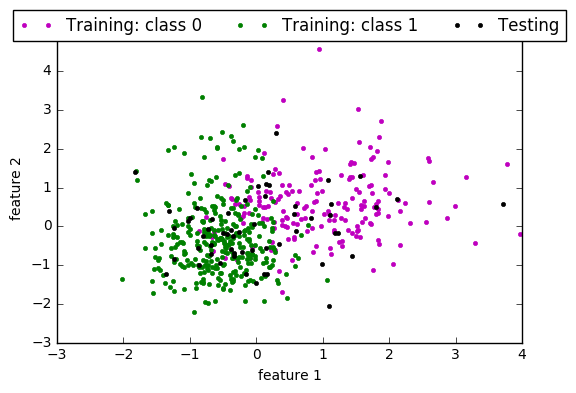

In [3]:
#%% divide the data to training and testing sets
bc = datasets.load_breast_cancer();
Data = [0.]*2;
Data[0] = bc.data;
Data[1] = bc.target;

X_train, X_test, y_train, y_test = train_test_split(Data[0],Data[1], test_size = 0.1)
X_test = (X_test- X_train.mean(axis = 0))/X_train.std(axis = 0)
X_train = (X_train-X_train.mean(axis = 0))/X_train.std(axis = 0)
num_samples, num_features = X_train.shape
Data_train = [X_train, y_train];
Data_test = [X_test, y_test];
_, ax = plt.subplots()
ax.plot(Data_train[0][Data_train[1]==0,0], Data_train[0][Data_train[1]==0,1], 'm.', label = 'Training: class 0')
ax.plot(Data_train[0][Data_train[1]==1,0], Data_train[0][Data_train[1]==1,1], 'g.', label = 'Training: class 1')
ax.plot(Data_test[0][Data_test[1]==0,0], Data_test[0][Data_test[1]==0,1], 'k.', label = 'Testing')
ax.plot(Data_test[0][Data_test[1]==1,0], Data_test[0][Data_test[1]==1,1], 'k.')
ax.legend(loc=9,bbox_to_anchor=(0.5, 1.1), ncol=3)
ax.set(xlabel = 'feature 1', ylabel = 'feature 2')
plt.show(ax)

# Build inference function based on variational bayes (VB)

In [4]:
hyp = [1., 1., 1e-20];
# Initiating a GP classification class
mdl = GP_classification(hyp, X_train, y_train, X_test, y_test);
nsamples_vr = tn.scalar(name = 'nsamples_vr', dtype='int32');
## VB_objective 
def onesample():
    logprior_prob, loglik_prob, logjoint_prob, logq_prob, z = mdl.sample_model()
    ELBO =  logjoint_prob - logq_prob;
    g_mu = tn.grad(ELBO, mdl.mu_z)
    g_tau = tn.grad(ELBO, mdl.tau_z)
    return  ELBO, g_mu, g_tau 
samples,_ = scan(onesample, n_steps = nsamples_vr);
ELBO = samples[0].mean(axis =0);
mean_g_mu = samples[1].mean(axis =0);
mean_g_tau = samples[2].mean(axis =0);

# Build training function

In [5]:
#%% training function
adam_updates = adam([-mean_g_mu, -mean_g_tau], [mdl.mu_z, mdl.tau_z], learning_rate=0.1)
#adagrad_updates = adagrad([-mean_g_mu, -mean_g_tau], [mdl.mu_z, mdl.tau_z], learning_rate=0.001)

trainFn = function(
inputs = [nsamples_vr],
outputs = [ELBO, mdl.pred_error()],
#updates = adagrad_updates
updates = adam_updates
)


# optimize proposal distribution by maximizing the evidence lower bound expression

In [6]:
maxiter = 100;
nsamples = 50; # samples from the proposal distribution to calculate E_q[log joint - log q]
ELBO_list = [];
for i in range(maxiter):
    out = trainFn(nsamples);
    ELBO_list.append(out[0]);
    print ("prediction error = %.2f %%" %out[1])

prediction error = 59.65 %
prediction error = 5.26 %
prediction error = 5.26 %
prediction error = 5.26 %
prediction error = 5.26 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction error = 3.51 %
prediction 

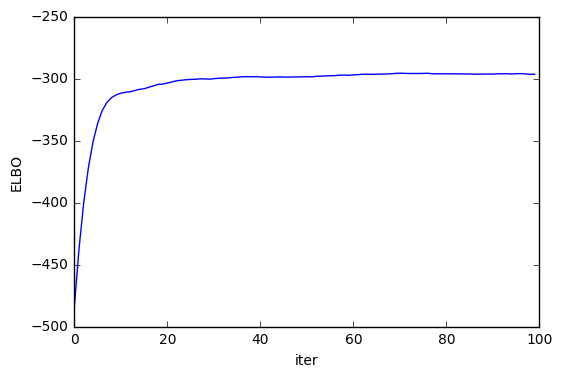

In [9]:
plt.plot(ELBO_list)
plt.xlabel('iter')
plt.ylabel('ELBO')
plt.show()
